# Libs

In [318]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Helpers

## Constants

In [319]:
features_datasus = ['date', 'hospitalizations','average_stay', 'deaths', 'mortality_rate']

In [320]:
test_start_date = "2017-01-01"

## Functions

In [321]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [322]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [323]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [324]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [325]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = mean_squared_error(y, predicted)
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

# Dataset

In [326]:
dataset = read_csv('datasets/datasets_prontos/dataset_without_geographic_data.csv', 
                   header=0, 
                   index_col=0,
                  usecols=features_datasus)

values = dataset.values

In [327]:
dataset

,hospitalizations,average_stay,deaths,mortality_rate
date,,,,
2000-12,4266,6.1,242,5.67
2001-01,4032,5.9,218,5.41
2001-02,3888,5.8,217,5.58
2001-03,3658,5.8,176,4.81
2001-04,4022,5.8,256,6.36
...,...,...,...,...
2024-05,3172,6.7,313,9.87
2024-06,3640,6.6,329,9.04
2024-07,3689,6.5,338,9.16


# Preprocessing

## Remoção ano 2000

In [328]:
dataset = dataset[(dataset.index >= "2001-01-01") & (dataset.index < "2020-01-01")]

test_start_date = '2017-01-01'

# Trainings

## Split train and test

In [329]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(192, 3) (192,)
(36, 3) (36,)


## Normalization

In [330]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(192, 3) (192, 1)
(36, 3) (36, 1)


## Test - unindo as features

In [331]:
df_train_scaled = np.hstack((df_train_scaled, y_train_scaled.reshape(-1, 1)))
df_test_scaled = np.hstack((df_test_scaled, y_test_scaled.reshape(-1, 1)))

## LSTM format

In [332]:
reframed_train = series_to_supervised(df_train_scaled, 1, 1)
reframed_test = series_to_supervised(df_test_scaled, 1, 1)

print("reframed train\n", reframed_train)
print("\nreframed test\n", reframed_test)

reframed train
      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)  var3(t)  \
1     0.266667   0.262069     0.1232   0.580952  0.266667  0.120690   0.0000   
2     0.266667   0.120690     0.0000   0.471429  0.266667  0.396552   0.2480   
3     0.266667   0.396552     0.2480   0.644762  0.533333  0.444828   0.2272   
4     0.533333   0.444828     0.2272   0.792381  0.266667  0.444828   0.2592   
5     0.266667   0.444828     0.2592   0.730000  0.266667  0.531034   0.3136   
..         ...        ...        ...        ...       ...       ...      ...   
187   0.800000   0.693103     0.7872   0.402857  0.866667  0.572414   0.6736   
188   0.866667   0.572414     0.6736   0.350000  0.733333  0.668966   0.6672   
189   0.733333   0.668966     0.6672   0.505238  0.800000  0.582759   0.6480   
190   0.800000   0.582759     0.6480   0.395238  0.733333  0.524138   0.7056   
191   0.733333   0.524138     0.7056   0.242381  0.533333  0.468966   0.6016   

      var4(t)  
1    0.

## Drop columns we don't want to predict

In [333]:
reframed_train.drop(reframed_train.columns[[5, 6, 7]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[5, 6, 7]], axis=1, inplace=True)

print(reframed_train.head())
print(reframed_test.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.266667   0.262069     0.1232   0.580952  0.266667
2   0.266667   0.120690     0.0000   0.471429  0.266667
3   0.266667   0.396552     0.2480   0.644762  0.533333
4   0.533333   0.444828     0.2272   0.792381  0.266667
5   0.266667   0.444828     0.2592   0.730000  0.266667
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.533333   0.375862     0.6304   0.090000  0.600000
2   0.600000   0.451724     0.5760   0.269524  0.666667
3   0.666667   0.368966     0.5168   0.199048  0.533333
4   0.533333   0.551724     0.5936   0.411429  0.666667
5   0.666667   0.631034     0.7520   0.352381  0.933333


## Split into input and outputs

In [334]:
# train_y = reframed_train['var1(t)']
# test_y = reframed_test['var1(t)']

# reframed_train = reframed_train.iloc[:, :-1]
# reframed_test = reframed_test.iloc[:, :-1]

train = reframed_train.values
test  = reframed_test.values

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

## Reshape input to be 3D [samples, timesteps, features]

In [335]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(191, 1, 4) (191,) (35, 1, 4) (35,)


## Treinamento

Epoch 1/100


/home/thiery/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 - 3s - 181ms/step - loss: 0.4823 - val_loss: 0.6534
Epoch 2/100
16/16 - 0s - 6ms/step - loss: 0.4482 - val_loss: 0.6163
Epoch 3/100
16/16 - 0s - 6ms/step - loss: 0.4112 - val_loss: 0.5748
Epoch 4/100
16/16 - 0s - 6ms/step - loss: 0.3692 - val_loss: 0.5265
Epoch 5/100
16/16 - 0s - 6ms/step - loss: 0.3210 - val_loss: 0.4696
Epoch 6/100
16/16 - 0s - 9ms/step - loss: 0.2674 - val_loss: 0.4044
Epoch 7/100
16/16 - 0s - 6ms/step - loss: 0.2119 - val_loss: 0.3316
Epoch 8/100
16/16 - 0s - 6ms/step - loss: 0.1605 - val_loss: 0.2541
Epoch 9/100
16/16 - 0s - 9ms/step - loss: 0.1275 - val_loss: 0.1978
Epoch 10/100
16/16 - 0s - 6ms/step - loss: 0.1205 - val_loss: 0.1715
Epoch 11/100
16/16 - 0s - 6ms/step - loss: 0.1215 - val_loss: 0.1627
Epoch 12/100
16/16 - 0s - 5ms/step - loss: 0.1224 - val_loss: 0.1642
Epoch 13/100
16/16 - 0s - 6ms/step - loss: 0.1218 - val_loss: 0.1649
Epoch 14/100
16/16 - 0s - 6ms/step - loss: 0.1212 - val_loss: 0.1644
Epoch 15/100
16/16 - 0s - 6ms/step - loss: 0.1208 - v

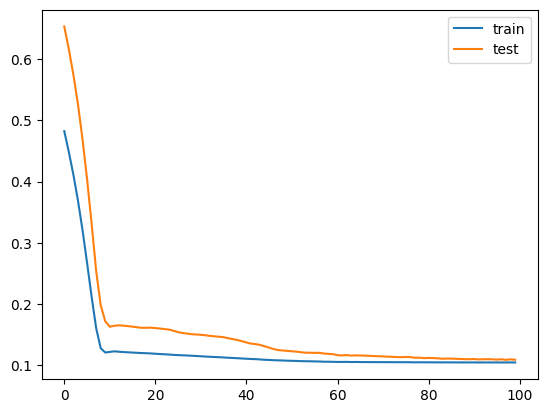

In [336]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# design network
model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(4))  # Segunda camada LSTM
model.add(Dense(1))  # Camada de saída
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, 
                    train_y, 
                    epochs=100, 
                    batch_size=12, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    callbacks=[early_stopping],
                    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


## Prediction

In [337]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler_target.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler_target.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Test RMSE: 290.557


In [338]:
inv_yhat

array([3774.32864237, 3821.48935127, 3791.60945344, 3825.93037415,
       4032.45708871, 4430.43319511, 4010.64575839, 4064.80671096,
       4108.05861878, 4178.33254862, 4002.62200165, 3918.91172457,
       3858.83800316, 3818.74287653, 3760.68776774, 3897.691571  ,
       4106.02310824, 4343.0349164 , 4204.0183835 , 4494.27953291,
       4237.148314  , 4126.03362131, 3927.12936926, 3977.06671882,
       3744.52059197, 3861.30860376, 3902.45978761, 3675.06677437,
       4090.57866263, 4168.41322112, 4120.03974247, 4071.61331701,
       4117.54122901, 4006.58337402, 3860.67787337])

In [339]:
print_metrics(inv_y, inv_yhat)

Mean Absolute Error (MAE): 227.86
Mean Squared Error (MSE): 84423.26
Root Mean Squared Error (RMSE): 84423.26
Mean Absolute Percentage Error (MAPE): 5.40%
R-Squared (R²): 0.23


In [340]:
test_pred = scaler_target.inverse_transform(yhat)
test_test = scaler_target.inverse_transform(test_y.reshape(-1, 1))

print_metrics(test_test, test_pred)

Mean Absolute Error (MAE): 227.86
Mean Squared Error (MSE): 84423.24
Root Mean Squared Error (RMSE): 84423.24
Mean Absolute Percentage Error (MAPE): 5.40%
R-Squared (R²): 0.23
